<a href="https://colab.research.google.com/github/stellagerantoni/MLChallenge/blob/main/traffic_lights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

In [2]:
!ls "/content/drive/MyDrive/"

 1497636324905991.pdf
 20180529193743463.pdf
'6 δεκ. 2020.gdoc'
 Classroom
'Colab Notebooks'
 --CV-3.pdf
 GTSRB-Training_fixed.zip
 presentations_2019_20.rar
 shmeivseis-Piuanothtes_2015.rar
'Untitled document.gdoc'
'Αριστερη Συσπειρωση Νο1.pdf'
 ΑΣ-ΑΣΦ.pdf
'Βασικές αρχές ΑΡΑΣ.doc'
'Βασικές ένοιες του ιστορικού υλισμού - Χαρνεκερ.pdf'
'Για τη σύγχρονη νεολαία και τα χαρακτηριστικά της ΑΣ 2014.pdf'
'Έγγραφο χωρίς τίτλο.gdoc'
'Εισήγηση camping 2013 Φασισμός.doc'
'Εισήγηση για το Κράτος.doc'
'Εισήγηση για τον εκπαιδευτικό μηχανισμό- Δεκέμβριος 2015.doc'
'Εισήγηση ΕΝΙΑΙΟ ΜΕΤΩΠΟ camping ΑΡΑΣ 2014.pdf'
'εισηγηση καμπινγκ 2016 teliko (1).doc'
'θέσεις αρας για λαε τέλη του 2016.pdf'
'Λένιν Για τον Μαρξ και τη διδασκαλία του.pdf'
'ΜΑΟ ΑΝΤΙΘΕΣΕΙΣ.doc'
'Ο εκπαιδευτικός μηχανισμός τη συγκυρία ΑΣ1.pdf'
'Οι Διανοουμενοι.pdf'


In [3]:
!unzip "/content/drive/MyDrive/GTSRB-Training_fixed" -d "/content/"

Archive:  /content/drive/MyDrive/GTSRB-Training_fixed.zip
replace /content/GTSRB/Training/00000/00000_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import random as python_random
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)

RANDOM_STATE = 39

In [5]:
#import zipfile
#import csv

train_images = []
train_labels = []
validation_images = []
validation_labels = []
test_images = []
test_labels = []
annotations=[]

In [6]:
# Importing the training data, its labels and the x,y values to cut the images and keep only the object we want the model to detect

root_folder = '/content/GTSRB/Training/'
dir_list_classes = sorted(os.listdir(root_folder))
for path in dir_list_classes[0:43]:
  dir_list_images = sorted(os.listdir(os.path.join(root_folder,path)))
  annotation = pd.read_csv(os.path.join(root_folder,path,dir_list_images[-1]),delimiter = ';')
  img_nb = 0
  for file in dir_list_images[:150]:
    img_path = os.path.join(root_folder,path)
    img = cv2.imread(os.path.join(img_path, file))

    x1 = annotation.loc[img_nb,'Roi.X1']
    y1 = annotation.loc[img_nb,'Roi.Y1']
    x2 = annotation.loc[img_nb,'Roi.X2']
    y2 = annotation.loc[img_nb,'Roi.Y2']

    cropped_img = img[y1:y2, x1:x2]

    resized_img = cv2.resize(cropped_img, (100, 100))
    train_images.append(resized_img)

    class_id = annotation.loc[img_nb,'ClassId']
    train_labels.append(class_id)
    img_nb +=1

In [43]:
img_nb

150

In [7]:
# Importing the testing data, its labels and the x,y values to cut the images and keep only the object we want the model to detect

root_folder_test = '/content/drive/MyDrive/Classroom/Final_Test/Images'
root_folder_test_dir = sorted(os.listdir(root_folder_test))
annotation_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GT-final_test.csv',delimiter = ';')
img_idx = 0
for path in root_folder_test_dir[0:12629]:
    img_path = os.path.join(root_folder_test,path)
    img = cv2.imread(img_path)

    x1 = annotation_test.loc[img_idx,'Roi.X1']
    y1 = annotation_test.loc[img_idx,'Roi.Y1']
    x2 = annotation_test.loc[img_idx,'Roi.X2']
    y2 = annotation_test.loc[img_idx,'Roi.Y2']

    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (100, 100))

    class_id_test = annotation_test.loc[img_idx,'ClassId']
    test_labels.append(class_id_test)

    test_images.append(resized_img)
    img_idx +=1

In [8]:
#shuffling the training data (testing data is already in no purticular order), and spliting the training data so that 20% becomes validation data.

from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=RANDOM_STATE)

from sklearn.model_selection import train_test_split
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

In [44]:
train_images.shape

(5160, 100, 100, 3)

In [45]:
validation_images.shape

(1290, 100, 100, 3)

In [9]:
#converting everything to a numpy array and normalizing the images so that all the values of the pixels are from 0 to 1.

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

train_images = train_images/255.0
test_images = test_images/255.0
validation_images = validation_images/255.0

In [11]:
#transforming the labels so that they are in a one hot encoding form for the model.
from keras.utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes = 43)
validation_labels_categorical = to_categorical(validation_labels, num_classes = 43)
test_labels_categorical = to_categorical(test_labels, num_classes = 43)

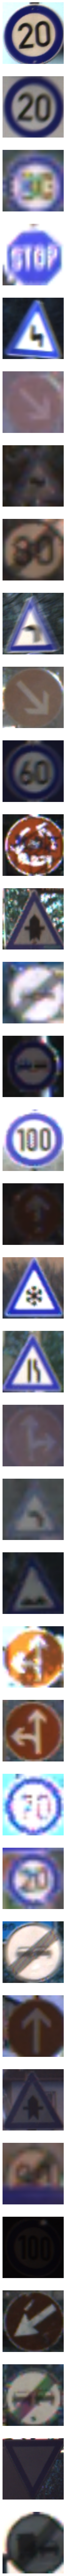

In [12]:
#just vitualising some photos to make shure that we cut the outline correctly
plt.figure(figsize=(60, 160))
count = 1
for j in range(train_images.shape[0]):
  if j %150 == 0:
    for i, image in enumerate(train_images[j:j+1]):
        plt.subplot(43, 1, count)
        plt.imshow(train_images[j])
        plt.axis('off')
        count += 1

plt.show()

ValueError: ignored

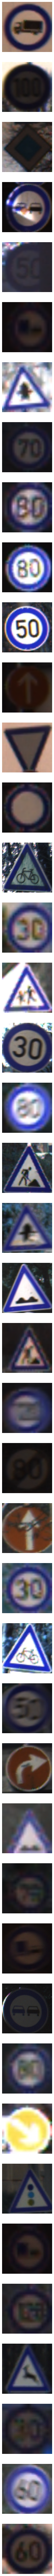

In [29]:
#just vitualising some photos to make shure that we cut the outline correctly
plt.figure(figsize=(60, 160))
count = 1
for j in range(test_images.shape[0]):
  if j %150 == 0:
    for i, image in enumerate(test_images[j:j+1]):
        plt.subplot(43, 1, count)
        plt.imshow(test_images[j])
        plt.axis('off')
        count += 1

plt.show()

This model is a regular cnn model. I tried diffrent parameters like less features (16,32,64) in the convolutional layers

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow import keras

model = tf.keras.Sequential([
    (Conv2D(32,kernel_size=(3,3), activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(64,kernel_size=(3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(128, kernel_size = (3,3), activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(128, activation= 'relu')),
    (Dropout(0.5)),
    (Dense(43, activation = 'softmax'))
])

In [42]:
train_images.shape

(5160, 100, 100, 3)

In [32]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history = model.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)

Epoch 1/150
162/162 [==============================] - 4s 11ms/step - loss: 3.5808 - accuracy: 0.0729 - val_loss: 3.1029 - val_accuracy: 0.3039
Epoch 2/150
162/162 [==============================] - 1s 7ms/step - loss: 2.7263 - accuracy: 0.2818 - val_loss: 1.8363 - val_accuracy: 0.6566
Epoch 3/150
162/162 [==============================] - 1s 7ms/step - loss: 1.7439 - accuracy: 0.5442 - val_loss: 1.0020 - val_accuracy: 0.8496
Epoch 4/150
162/162 [==============================] - 1s 7ms/step - loss: 1.1340 - accuracy: 0.7048 - val_loss: 0.6070 - val_accuracy: 0.9140
Epoch 5/150
162/162 [==============================] - 1s 7ms/step - loss: 0.8116 - accuracy: 0.7895 - val_loss: 0.4407 - val_accuracy: 0.9310
Epoch 6/150
162/162 [==============================] - 1s 7ms/step - loss: 0.6391 - accuracy: 0.8312 - val_loss: 0.2941 - val_accuracy: 0.9550
Epoch 7/150
162/162 [==============================] - 1s 7ms/step - loss: 0.4947 - accuracy: 0.8703 - val_loss: 0.2274 - val_accuracy: 0.960

In [41]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
print(f"Classifier trained, with validation accuracy {acc}.")

395/395 [==============================] - 1s 3ms/step
Classifier trained, with validation accuracy 0.8142795537278786.


In [21]:
# Simpler model
model2 = tf.keras.Sequential([
    (Conv2D(16,kernel_size=(3,3), padding = 'same', activation = 'relu', input_shape = (100,100,3))),
    (MaxPooling2D(pool_size = (2,2))),

    (Conv2D(32,kernel_size=(3,3), padding = 'same', activation = 'relu')),
    (MaxPooling2D(pool_size = (2,2))),

    (Flatten()),
    (Dense(32, activation= 'relu')),
    (Dense(43, activation = 'softmax'))
])

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
reset_seeds()
classifier_history2 = model2.fit(
    train_images,
    train_labels_categorical,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(validation_images, validation_labels_categorical),
    callbacks=[early_stopping_accuracy],
)

Epoch 1/150
162/162 [==============================] - 3s 9ms/step - loss: 3.6518 - accuracy: 0.0529 - val_loss: 3.4995 - val_accuracy: 0.0938
Epoch 2/150
162/162 [==============================] - 1s 6ms/step - loss: 3.3058 - accuracy: 0.1304 - val_loss: 3.1728 - val_accuracy: 0.1628
Epoch 3/150
162/162 [==============================] - 1s 6ms/step - loss: 2.9211 - accuracy: 0.2227 - val_loss: 2.7518 - val_accuracy: 0.2729
Epoch 4/150
162/162 [==============================] - 1s 6ms/step - loss: 2.5731 - accuracy: 0.3172 - val_loss: 2.4447 - val_accuracy: 0.3248
Epoch 5/150
162/162 [==============================] - 1s 6ms/step - loss: 2.2500 - accuracy: 0.4012 - val_loss: 2.1875 - val_accuracy: 0.3752
Epoch 6/150
162/162 [==============================] - 1s 6ms/step - loss: 1.9536 - accuracy: 0.4684 - val_loss: 1.8228 - val_accuracy: 0.5023
Epoch 7/150
162/162 [==============================] - 1s 6ms/step - loss: 1.6868 - accuracy: 0.5335 - val_loss: 1.6506 - val_accuracy: 0.5481

In [39]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = accuracy_score(y_true=test_labels, y_pred=y_pred_classes)
print(f"Classifier trained, with validation accuracy {acc}.")

395/395 [==============================] - 1s 3ms/step
Classifier trained, with validation accuracy 0.5771636709161454.


In [36]:
# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(classifier_history.history['accuracy'], label='Training Accuracy')
plt.plot(classifier_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(classifier_history.history['loss'], label='Training Loss')
plt.plot(classifier_history.history['val_loss'], label='Validation Loss')
plt.plot(test_loss,labels = )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

395/395 [==============================] - 2s 4ms/step - loss: 1.3233 - accuracy: 0.7887
Test accuracy: 0.788661003112793
